In [1]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)
    
from src.predictionModule.LoadupSamples import LoadupSamples
from src.predictionModule.FilterSamples import FilterSamples
from src.predictionModule.MachineModels import MachineModels

import numpy as np
import pandas as pd
import polars as pl
import datetime
import scipy

import logging
formatted_date = datetime.datetime.now().strftime("%d%b%y_%H%M").lower()

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter(fmt="%(asctime)s - %(message)s")
handler.setFormatter(formatter)
if not logger.hasHandlers():
    logger.addHandler(handler)
else:
    logger.handlers[:] = [handler]

#Output File handler
formatted_str = f"notebook-stomp-{formatted_date}"
file_handler = logging.FileHandler(f"{formatted_str}.log", mode="w")
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Usage
logger.setLevel(logging.INFO)
logger.info("This will print to the notebook's output cell")

2025-09-05 17:28:54,886 - This will print to the notebook's output cell


In [2]:
params = {
    "idxAfterPrediction": 5,
    'timesteps': 90,
    'target_option': 'last',
    "LoadupSamples_time_scaling_stretch": True,
    "LoadupSamples_time_inc_factor": 61,

    "FilterSamples_q_up": 0.985,
    
    "FilterSamples_cat_over20": True,
    "FilterSamples_cat_posOneYearReturn": False,
    "FilterSamples_cat_posFiveYearReturn": False,
}

In [38]:
timegroup = "group_regOHLCV_over5years"
treegroup = "group_finanTo2011"

eval_date = datetime.date(year=2024, month=2, day=13)
evaldates = [eval_date - datetime.timedelta(days=i) for i in range(1, 6)]
start_train_date = datetime.date(year=2022, month=6, day=1)
split_Date = datetime.date(year=2024, month=1, day=1)
ls = LoadupSamples(
    train_start_date=start_train_date,
    test_dates=evaldates,
    treegroup=treegroup,
    timegroup=timegroup,
    params=params,
)
ls.load_samples(main_path = "../src/featureAlchemy/bin/")
ls.split_dataset(
    start_date=start_train_date,
    last_train_date=split_Date,
    last_test_date=eval_date
)
fs_pre = FilterSamples(
    Xtree_train = ls.train_Xtree, 
    ytree_train = ls.train_ytree, 
    treenames   = ls.featureTreeNames,
    Xtree_test  = ls.test_Xtree,  
    ytree_test  = ls.test_ytree,
    meta_train  = ls.meta_pl_train, 
    meta_test   = ls.meta_pl_test, 
    params      = params
)
mask_train_pre, mask_test_pre = fs_pre.categorical_masks()
ls.apply_masks(mask_train_pre, mask_test_pre)

2025-09-05 17:49:28,928 - Test date 2024-02-11 not found in the database. Omitting.
2025-09-05 17:49:28,944 - Test date 2024-02-10 not found in the database. Omitting.
2025-09-05 17:49:31,116 - Non-finite/too-large values in train X tree: 86 samples.
2025-09-05 17:49:31,116 - Removing 86 samples from training data.


In [39]:
Xtree_train = ls.train_Xtree
ytree_train = ls.train_ytree
Xtree_test  = ls.test_Xtree
ytree_test  = ls.test_ytree

Xtime_train = ls.train_Xtime
ytime_train = ls.train_ytime
Xtime_test  = ls.test_Xtime
ytime_test  = ls.test_ytime

treenames   = ls.featureTreeNames
timenames   = ls.featureTimeNames
meta_train  = ls.meta_pl_train
meta_test   = ls.meta_pl_test

In [48]:
# ==== Imports ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ==== Data (expected in workspace) ====
# Xtime_train: (nS, nT, nF)
# ytime_train: (nS, nT) or (nS,)
# Optional: Xtime_test, ytime_test
# Optional: timenames: list[str] length nT

# ---- If your variables are named differently, alias them here ----
# ytime_train = ytree_train
# ytime_test  = ytree_test

# ==== Global toggles (edit freely) ====
RANDOM_STATE = 42
KMEANS_N_INIT = 10  # set to 10 if using older scikit-learn
KMEANS_INIT = "k-means++"  # or "random"

# search space
TIME_WINDOWS = [5, 10, "full"]   # "full" will be replaced by nT
MAX_SINGLETON_FEATS = 2           # how many single-feature runs (at most)
CLUSTER_KS = [5]
TOP_N_VIS = 2                     # how many top configs to visualize

# ==== Basic checks ====
assert "Xtime_train" in globals() and "ytree_train" in globals(), "Provide Xtime_train and ytree_train"
nS, nT, nF = Xtime_train.shape

ytr_arr = np.asarray(ytree_train)
ytr_vec = ytr_arr[:, -1] if ytr_arr.ndim == 2 else ytr_arr

has_test = "Xtime_test" in globals() and "ytree_test" in globals()
yte_vec = None
if has_test:
    yte_arr = np.asarray(ytree_test)
    yte_vec = yte_arr[:, -1] if yte_arr.ndim == 2 else yte_arr

# Expand time windows
time_windows = []
for w in TIME_WINDOWS:
    if w == "full":
        time_windows.append(nT)
    elif isinstance(w, int) and 1 <= w <= nT:
        time_windows.append(w)
time_windows = sorted(set(time_windows))

# Feature sets: all + capped singletons
feature_sets = [("all", np.arange(nF))]
for j in range(min(MAX_SINGLETON_FEATS, nF)):
    feature_sets.append((f"f{j}", np.array([j])))


In [49]:
def geometric_mean_safe(arr):
    arr = np.asarray(arr, dtype=float)
    minv = np.min(arr) if arr.size else 0.0
    shift = -minv + 1e-9 if minv <= 0 else 0.0
    return float(np.exp(np.mean(np.log(arr + shift)))) if arr.size else np.nan

def metric(arr):
    """Custom cluster score function."""
    gm = geometric_mean_safe(arr)
    return gm - 1

def make_design(X, t_win, feat_idx):
    feat_idx = np.atleast_1d(feat_idx)
    Xw = X[:, -t_win:, feat_idx]
    return Xw.reshape(Xw.shape[0], -1)

def run_search(
    Xtr, ytr_vec, time_windows, feature_sets, cluster_ks,
    random_state=42, n_init="auto",
    Xte=None, yte_vec=None
):
    has_test = Xte is not None and yte_vec is not None
    out = []

    for t_win, (f_name, f_idx), k in product(time_windows, feature_sets, cluster_ks):
        # === Design matrices ===
        Xd_tr = make_design(Xtr, t_win, f_idx)
        if k >= len(Xd_tr):
            continue

        scaler = StandardScaler().fit(Xd_tr)
        Xs_tr = scaler.transform(Xd_tr)

        Xs_te = None
        if has_test:
            Xd_te = make_design(Xte, t_win, f_idx)
            Xs_te = scaler.transform(Xd_te)

        # === Fit on TRAIN; predict TEST ===
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state).fit(Xs_tr)
        lab_tr = km.labels_
        lab_te = km.predict(Xs_te) if has_test else None

        # === Per-cluster scores & counts ===
        train_scores, test_scores, ntr, nte = [], [], [], []
        for c in range(k):
            idx_tr = np.where(lab_tr == c)[0]
            ntr.append(len(idx_tr))
            tr_s = metric(ytr_vec[idx_tr]) if len(idx_tr) else np.nan
            train_scores.append(tr_s)

            if has_test:
                idx_te = np.where(lab_te == c)[0]
                nte.append(len(idx_te))
                te_s = metric(yte_vec[idx_te]) if len(idx_te) else np.nan
                test_scores.append(te_s)
            else:
                nte.append(np.nan)
                test_scores.append(np.nan)

        # === “Analyze all combos”: tie TRAIN to TEST via train-best cluster ===
        best_c_train = int(np.nanargmax(train_scores))
        best_train = train_scores[best_c_train]
        paired_test = test_scores[best_c_train]
        delta = paired_test - best_train if np.isfinite(paired_test) else np.nan
        rel_delta = (delta / (abs(best_train) + 1e-12)) if np.isfinite(delta) else np.nan

        # also record test-best if test exists
        if has_test and np.any(np.isfinite(test_scores)):
            best_c_test = int(np.nanargmax(test_scores))
            best_test = test_scores[best_c_test]
        else:
            best_c_test, best_test = np.nan, np.nan

        out.append({
            "time_window": int(t_win),
            "feature_set": f_name,
            "n_features": int(len(np.atleast_1d(f_idx))),
            "k": int(k),

            # labels for reuse/plots
            "labels_tr": lab_tr,
            "labels_te": lab_te,

            # full vectors (for analysis)
            "train_scores": train_scores,
            "test_scores": test_scores,
            "train_counts": ntr,
            "test_counts": nte,

            # train-best linked analysis
            "best_c_train": best_c_train,
            "best_score_train": float(best_train),
            "paired_test_score": float(paired_test) if np.isfinite(paired_test) else np.nan,
            "delta_test_minus_train": float(delta) if np.isfinite(delta) else np.nan,
            "rel_delta": float(rel_delta) if np.isfinite(rel_delta) else np.nan,

            # test-best (optional)
            "best_c_test": best_c_test,
            "best_score_test": float(best_test) if np.isfinite(best_test) else np.nan,

            # for reproducibility
            "features_idx": np.atleast_1d(f_idx),
        })

    res_df = pd.DataFrame(out)

    # Default sort: prioritize generalization (paired_test_score), then train strength
    if "paired_test_score" in res_df.columns:
        res_df = res_df.sort_values(
            ["paired_test_score", "best_score_train"],
            ascending=[False, False]
        ).reset_index(drop=True)

    return res_df

def visualize_top_configs(res_df, Xtr, Xte=None, topN=3, random_state=42):
    topN = min(topN, len(res_df))
    for r in range(topN):
        row = res_df.iloc[r]
        t_win = int(row.time_window)
        f_idx = row.features_idx
        k = int(row.k)
        lab_tr = row.labels_tr
        lab_te = row.labels_te
        tr_scores = row.train_scores
        te_scores = row.test_scores

        # --- Bar chart: TRAIN vs TEST per cluster ---
        x = np.arange(k)
        w = 0.4
        plt.figure(figsize=(6,4))
        plt.bar(x - w/2, tr_scores, width=w, label="Train")
        plt.bar(x + w/2, te_scores, width=w, label="Test")
        plt.xticks(x, [f"C{c}" for c in range(k)])
        plt.ylabel("Cluster Score (metric)")
        plt.title(f"Scores per cluster | win={t_win}, feats={len(np.atleast_1d(f_idx))} ({row.feature_set}), k={k}")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # --- PCA: fit on TRAIN; project TRAIN+TEST ---
        Xd_tr = make_design(Xtr, t_win, f_idx)
        scaler = StandardScaler().fit(Xd_tr)
        Xs_tr = scaler.transform(Xd_tr)
        pca = PCA(n_components=2, random_state=random_state).fit(Xs_tr)
        XY_tr = pca.transform(Xs_tr)

        plt.figure(figsize=(6,5))
        for c in range(k):
            idx = np.where(lab_tr == c)[0]
            plt.scatter(XY_tr[idx,0], XY_tr[idx,1], label=f"Train C{c}", s=14, alpha=0.8)

        if Xte is not None and lab_te is not None:
            Xd_te = make_design(Xte, t_win, f_idx)
            Xs_te = scaler.transform(Xd_te)
            XY_te = pca.transform(Xs_te)
            for c in range(k):
                idx = np.where(lab_te == c)[0]
                plt.scatter(XY_te[idx,0], XY_te[idx,1], marker="x", s=18, alpha=0.8, label=f"Test C{c}")

        plt.legend(title="Cluster / Split", ncol=2)
        plt.title(f"PCA(2) | win={t_win}, feats={len(np.atleast_1d(f_idx))} ({row.feature_set}), k={k}")
        plt.tight_layout()
        plt.show()


In [50]:
res_df = run_search(
    Xtr=Xtime_train,
    ytr_vec=ytr_vec,
    time_windows=time_windows,
    feature_sets=feature_sets,
    cluster_ks=CLUSTER_KS,
    random_state=RANDOM_STATE,
    n_init=KMEANS_N_INIT,
    Xte=(Xtime_test if has_test else None),
    yte_vec=(yte_vec if has_test else None),
)

# Quick views you can tweak:
display(res_df.head(10))
# e.g., best by generalization drop:
display(res_df.sort_values(["rel_delta"], ascending=True).head(10))

,time_window,feature_set,n_features,k,labels_tr,labels_te,train_scores,test_scores,train_counts,test_counts,best_c_train,best_score_train,paired_test_score,delta_test_minus_train,rel_delta,best_c_test,best_score_test,features_idx
0,5,f0,1,5,"[0, 4, 1, 1, 4, 4, 4, 4, 1, 4, 4, 4, 1, 0, 4, ...","[4, 4, 2, 0, 0, 4, 0, 0, 0, 2, 0, 4, 2, 3, 2, ...","[0.0015361098636019754, -0.0008076845304259006...","[0.0049970721635692605, 0.0012404758581818776,...","[67854, 68714, 20749, 20616, 106926]","[4875, 4711, 1462, 821, 8410]",0,0.001536,0.004997,0.003461,2.253070,2,0.005320,[0]
1,10,f0,1,5,"[2, 2, 3, 0, 3, 2, 3, 3, 0, 3, 3, 3, 0, 2, 3, ...","[2, 3, 4, 2, 1, 3, 2, 2, 2, 4, 2, 3, 4, 0, 4, ...","[0.0005966732923410323, 0.0012243853855502529,...","[-0.0022521456308732812, 0.00359446466741975, ...","[38987, 54004, 66061, 89140, 36667]","[1553, 4248, 5117, 6665, 2696]",1,0.001224,0.003594,0.002370,1.935730,4,0.006939,[0]
2,10,all,2,5,"[1, 1, 4, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 4, 4, ...","[2, 2, 3, 2, 3, 2, 3, 2, 4, 3, 2, 2, 3, 0, 3, ...","[0.0005653645729515322, 0.0030999244575411478,...","[-0.001930029941498712, 0.0020983095197997237,...","[62865, 22003, 116957, 56424, 26610]","[3104, 1678, 9915, 4195, 1387]",1,0.003100,0.002098,-0.001002,-0.323109,4,0.008761,"[0, 1]"
3,90,f1,1,5,"[1, 2, 0, 3, 3, 2, 4, 4, 4, 3, 2, 3, 0, 2, 3, ...","[3, 3, 2, 3, 3, 4, 3, 0, 0, 3, 0, 3, 3, 1, 3, ...","[0.002938240738267206, -0.00042770964207516915...","[0.0019352813948834147, 0.0017792548268482644,...","[43472, 17371, 35107, 143815, 45094]","[3448, 1437, 1194, 10480, 3720]",0,0.002938,0.001935,-0.001003,-0.341347,3,0.003487,[1]
4,5,f1,1,5,"[2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, ...","[1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.00037507662140945364, 9.820153580042401e-05...","[0.0022156358825156097, 0.0031508337645185236,...","[22578, 210637, 17096, 17389, 17159]","[1413, 15381, 1172, 1042, 1271]",3,0.003540,0.001770,-0.001770,-0.499958,1,0.003151,[1]
5,5,all,2,5,"[4, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 3, ...","[3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 0, 1, ...","[-0.0011905257064688257, -0.001205776142068293...","[0.0005090894629056208, 0.005674861330842829, ...","[53963, 47064, 25469, 136621, 21742]","[2906, 3386, 1612, 10763, 1612]",2,0.003036,0.001338,-0.001698,-0.559203,1,0.005675,"[0, 1]"
6,10,f1,1,5,"[1, 2, 2, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 2, 4, ...","[3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 3, ...","[0.0010031027336441234, 0.0030064283002015912,...","[0.001298453991637638, 0.0011164513580057545, ...","[26445, 22155, 24556, 186579, 25124]","[1990, 1482, 1338, 14492, 977]",1,0.003006,0.001116,-0.001890,-0.628645,2,0.008311,[1]
7,90,f0,1,5,"[0, 0, 0, 4, 4, 3, 3, 0, 0, 3, 4, 1, 3, 2, 3, ...","[4, 4, 2, 4, 4, 4, 0, 2, 4, 2, 4, 3, 4, 0, 4, ...","[0.0027173871832519847, -0.0005371008700588709...","[0.000795290858112141, 0.004754226556654695, 0...","[85415, 31420, 42639, 45187, 80198]","[1734, 1578, 8079, 1265, 7623]",3,0.003471,-0.004936,-0.008407,-2.422039,2,0.006436,[0]
8,90,all,2,5,"[4, 2, 4, 1, 1, 4, 4, 4, 4, 4, 1, 3, 0, 3, 4, ...","[1, 1, 3, 0, 1, 1, 4, 1, 1, 3, 1, 0, 1, 4, 0, ...","[0.0018279054094783032, -0.0014658758142284123...","[-0.0041509112298658835, 0.0022724130822271427...","[35208, 90267, 65519, 46754, 47111]","[1482, 11339, 1580, 5131, 747]",4,0.003501,-0.006171,-0.009672,-2.762673,3,0.007320,"[0, 1]"


,time_window,feature_set,n_features,k,labels_tr,labels_te,train_scores,test_scores,train_counts,test_counts,best_c_train,best_score_train,paired_test_score,delta_test_minus_train,rel_delta,best_c_test,best_score_test,features_idx
8,90,all,2,5,"[4, 2, 4, 1, 1, 4, 4, 4, 4, 4, 1, 3, 0, 3, 4, ...","[1, 1, 3, 0, 1, 1, 4, 1, 1, 3, 1, 0, 1, 4, 0, ...","[0.0018279054094783032, -0.0014658758142284123...","[-0.0041509112298658835, 0.0022724130822271427...","[35208, 90267, 65519, 46754, 47111]","[1482, 11339, 1580, 5131, 747]",4,0.003501,-0.006171,-0.009672,-2.762673,3,0.007320,"[0, 1]"
7,90,f0,1,5,"[0, 0, 0, 4, 4, 3, 3, 0, 0, 3, 4, 1, 3, 2, 3, ...","[4, 4, 2, 4, 4, 4, 0, 2, 4, 2, 4, 3, 4, 0, 4, ...","[0.0027173871832519847, -0.0005371008700588709...","[0.000795290858112141, 0.004754226556654695, 0...","[85415, 31420, 42639, 45187, 80198]","[1734, 1578, 8079, 1265, 7623]",3,0.003471,-0.004936,-0.008407,-2.422039,2,0.006436,[0]
6,10,f1,1,5,"[1, 2, 2, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 2, 4, ...","[3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 3, ...","[0.0010031027336441234, 0.0030064283002015912,...","[0.001298453991637638, 0.0011164513580057545, ...","[26445, 22155, 24556, 186579, 25124]","[1990, 1482, 1338, 14492, 977]",1,0.003006,0.001116,-0.001890,-0.628645,2,0.008311,[1]
5,5,all,2,5,"[4, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 3, ...","[3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 0, 1, ...","[-0.0011905257064688257, -0.001205776142068293...","[0.0005090894629056208, 0.005674861330842829, ...","[53963, 47064, 25469, 136621, 21742]","[2906, 3386, 1612, 10763, 1612]",2,0.003036,0.001338,-0.001698,-0.559203,1,0.005675,"[0, 1]"
4,5,f1,1,5,"[2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, ...","[1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.00037507662140945364, 9.820153580042401e-05...","[0.0022156358825156097, 0.0031508337645185236,...","[22578, 210637, 17096, 17389, 17159]","[1413, 15381, 1172, 1042, 1271]",3,0.003540,0.001770,-0.001770,-0.499958,1,0.003151,[1]
3,90,f1,1,5,"[1, 2, 0, 3, 3, 2, 4, 4, 4, 3, 2, 3, 0, 2, 3, ...","[3, 3, 2, 3, 3, 4, 3, 0, 0, 3, 0, 3, 3, 1, 3, ...","[0.002938240738267206, -0.00042770964207516915...","[0.0019352813948834147, 0.0017792548268482644,...","[43472, 17371, 35107, 143815, 45094]","[3448, 1437, 1194, 10480, 3720]",0,0.002938,0.001935,-0.001003,-0.341347,3,0.003487,[1]
2,10,all,2,5,"[1, 1, 4, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 4, 4, ...","[2, 2, 3, 2, 3, 2, 3, 2, 4, 3, 2, 2, 3, 0, 3, ...","[0.0005653645729515322, 0.0030999244575411478,...","[-0.001930029941498712, 0.0020983095197997237,...","[62865, 22003, 116957, 56424, 26610]","[3104, 1678, 9915, 4195, 1387]",1,0.003100,0.002098,-0.001002,-0.323109,4,0.008761,"[0, 1]"
1,10,f0,1,5,"[2, 2, 3, 0, 3, 2, 3, 3, 0, 3, 3, 3, 0, 2, 3, ...","[2, 3, 4, 2, 1, 3, 2, 2, 2, 4, 2, 3, 4, 0, 4, ...","[0.0005966732923410323, 0.0012243853855502529,...","[-0.0022521456308732812, 0.00359446466741975, ...","[38987, 54004, 66061, 89140, 36667]","[1553, 4248, 5117, 6665, 2696]",1,0.001224,0.003594,0.002370,1.935730,4,0.006939,[0]
0,5,f0,1,5,"[0, 4, 1, 1, 4, 4, 4, 4, 1, 4, 4, 4, 1, 0, 4, ...","[4, 4, 2, 0, 0, 4, 0, 0, 0, 2, 0, 4, 2, 3, 2, ...","[0.0015361098636019754, -0.0008076845304259006...","[0.0049970721635692605, 0.0012404758581818776,...","[67854, 68714, 20749, 20616, 106926]","[4875, 4711, 1462, 821, 8410]",0,0.001536,0.004997,0.003461,2.253070,2,0.005320,[0]


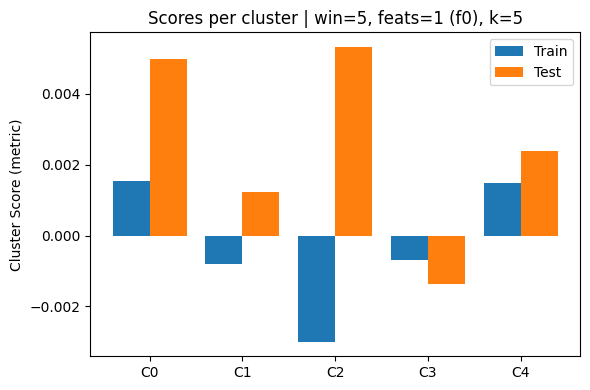

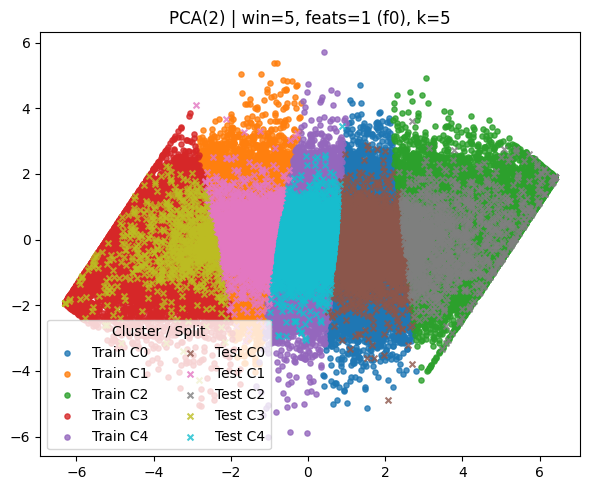

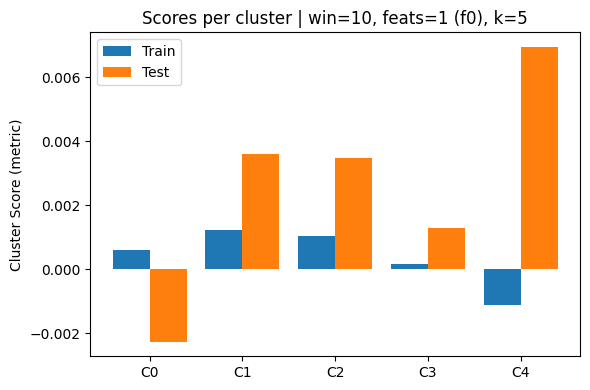

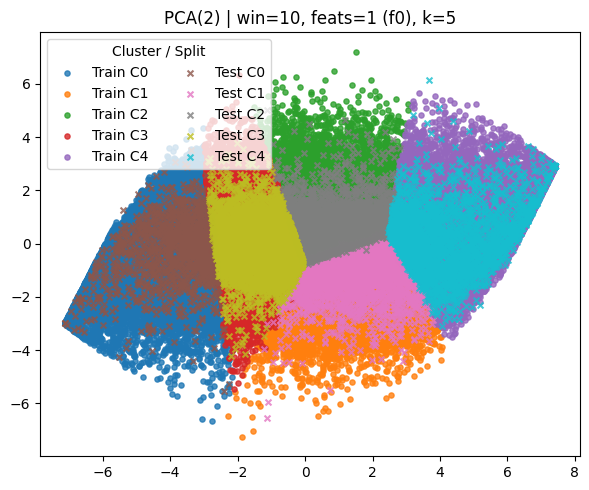

In [51]:
visualize_top_configs(
    res_df,
    Xtr=Xtime_train,
    Xte=(Xtime_test if has_test else None),
    topN=TOP_N_VIS,
    random_state=RANDOM_STATE
)